In [1]:
import rdkit
print(rdkit.__version__)
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


import numpy as np
import pandas as pd
from rdkit.Chem import rdmolfiles
from rdkit.Chem.rdmolfiles import SmilesMolSupplier
from rdkit.Chem import SDMolSupplier
from rdkit.Chem import AllChem, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import SaltRemover
import os
import subprocess
import matplotlib.pyplot as plt


2021.03.2


<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
# read in the two CSV files as pandas dataframes
df1 = pd.read_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/pubchem/AID_743139_datatable_active.csv')
df2 = pd.read_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/pubchem/AID_743139_datatable_inactive.csv')

df1_useful = df1.drop(index=range(0,3))
df1_useful2 = df1_useful[['PUBCHEM_EXT_DATASOURCE_SMILES','PUBCHEM_SID', 'PUBCHEM_ACTIVITY_OUTCOME']]

df2_useful = df2.drop(index=range(0,3))
df2_useful2 = df2_useful[['PUBCHEM_EXT_DATASOURCE_SMILES','PUBCHEM_SID', 'PUBCHEM_ACTIVITY_OUTCOME']]
print(len(df1_useful2), len(df2_useful2))
# merge the two dataframes on the common column(s)
df = pd.concat([df1_useful2, df2_useful2])

379 7562


In [3]:
df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME
3,CC(C)(C)C1=CC=C(C=C1)CN2CCN(CC2)C(C3=CC=CC=C3)...,144203574.0,Active
4,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144203575.0,Active
5,CC[C@@]12CCCN3[C@@H]1C4=C(CC3)C5=CC=CC=C5N4C(=...,144203611.0,Active
6,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,144203662.0,Active
7,CC1=[N+](C2=CC=CC=C2C(=C1)N)CCCCCCCCCC[N+]3=C(...,144203679.0,Active
...,...,...,...
7560,CCCSP(=O)(OCC)SCCC,144214043.0,Inactive
7561,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,144214045.0,Inactive
7562,CC(C)OC1=CC=CC(=C1)NC(=O)C2=CC=CC=C2C(F)(F)F,144214046.0,Inactive
7563,CCCCOCCOCCOCC1=CC2=C(C=C1CCC)OCO2,144214047.0,Inactive


In [4]:
df.dropna(subset = ['PUBCHEM_EXT_DATASOURCE_SMILES'],inplace=True)
len(df)

7844

In [5]:
#from same folder import src
import sys
sys.path.append('/home/sliu/cyp_related_coding/RF_CYP19/clean_code/')
from src.MoleculePreprocessorExtended import MoleculePreprocessorExtended

In [6]:
moleculesProcessed = MoleculePreprocessorExtended.init_with_smiles(list(df.PUBCHEM_EXT_DATASOURCE_SMILES))

RDKit ERROR: [12:53:56] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit WARNING: [12:53:56] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:53:56] Explicit valence for atom # 1 Si, 8, is greater than permitted


In [7]:
from rdkit import RDLogger
moleculesProcessed.csp_wash()

RDKit WARNING: [12:54:29] Tautomer enumeration stopped at 349 tautomers: max transforms reached
RDKit WARNING: [12:54:29] Tautomer enumeration stopped at 346 tautomers: max transforms reached
RDKit WARNING: [12:54:30] Tautomer enumeration stopped at 424 tautomers: max transforms reached
RDKit WARNING: [12:54:30] Tautomer enumeration stopped at 418 tautomers: max transforms reached
RDKit WARNING: [12:54:31] Tautomer enumeration stopped at 249 tautomers: max transforms reached
RDKit WARNING: [12:54:31] Tautomer enumeration stopped at 613 tautomers: max transforms reached
RDKit WARNING: [12:54:32] Tautomer enumeration stopped at 349 tautomers: max transforms reached
RDKit WARNING: [12:54:32] Tautomer enumeration stopped at 360 tautomers: max transforms reached
RDKit WARNING: [12:54:33] Tautomer enumeration stopped at 165 tautomers: max transforms reached
RDKit WARNING: [12:54:33] Tautomer enumeration stopped at 164 tautomers: max transforms reached
RDKit WARNING: [12:54:34] Tautomer enume

In [8]:
preprocessedSmilesDict = moleculesProcessed.get_rawsmiles_smiles_dict()

In [9]:
preprocessedSmiles_df = pd.DataFrame(list(preprocessedSmilesDict.items()), columns=['rawSmiles','preprocessedSmiles'])


In [10]:
preprocessed_df = pd.merge(df, preprocessedSmiles_df, 
                           left_on='PUBCHEM_EXT_DATASOURCE_SMILES', right_on='rawSmiles')

In [11]:
preprocessed_df.dropna(subset=['preprocessedSmiles'],inplace=True) 

In [12]:
preprocessed_df = preprocessed_df[preprocessed_df['preprocessedSmiles']!='']

In [13]:
len(preprocessed_df)

3053

In [14]:
def remove_stereochemistry(smiles):
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    # Use the Chem.RemoveStereochemistry function to remove stereo informationz
    Chem.RemoveStereochemistry(mol)
    
    # Convert the molecule back to a SMILES string without stereochemistry
    return Chem.MolToSmiles(mol)

preprocessed_df['preprocessedSmiles'] = preprocessed_df['preprocessedSmiles'].apply(remove_stereochemistry)
preprocessed_df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,rawSmiles,preprocessedSmiles
0,CC(C)(C)C1=CC=C(C=C1)CN2CCN(CC2)C(C3=CC=CC=C3)...,144203574.0,Active,CC(C)(C)C1=CC=C(C=C1)CN2CCN(CC2)C(C3=CC=CC=C3)...,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...
1,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144203575.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
2,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144205610.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
3,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144211864.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
4,CC[C@@]12CCCN3[C@@H]1C4=C(CC3)C5=CC=CC=C5N4C(=...,144203611.0,Active,CC[C@@]12CCCN3[C@@H]1C4=C(CC3)C5=CC=CC=C5N4C(=...,CCC12CCCN3CCc4c(n(c5ccccc45)C(=O)C1)C32
...,...,...,...,...,...
7838,C1=C(C(=NC(=C1Cl)Cl)OCC(=O)O)Cl,144214034.0,Inactive,C1=C(C(=NC(=C1Cl)Cl)OCC(=O)O)Cl,O=C(O)COc1nc(Cl)c(Cl)cc1Cl
7839,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)O,144214037.0,Inactive,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)O,CCCCC(CC)COC(=O)c1ccccc1C(=O)O
7840,CCOP(=O)(NC(C)C)OC1=CC(=C(C=C1)SC)C,144214042.0,Inactive,CCOP(=O)(NC(C)C)OC1=CC(=C(C=C1)SC)C,CCOP(=O)(NC(C)C)Oc1ccc(SC)c(C)c1
7842,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,144214045.0,Inactive,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC


In [15]:
duplicates = preprocessed_df.duplicated('preprocessedSmiles', keep=False)

# Filter DataFrame to list duplicates with their information
duplicates_df = preprocessed_df[duplicates]
duplicates_df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,rawSmiles,preprocessedSmiles
1,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144203575.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
2,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144205610.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
3,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144211864.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
5,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,144203662.0,Active,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
6,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,144210733.0,Active,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
...,...,...,...,...,...
7507,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,144212843.0,Inactive,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,CC1(C(=O)O)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O...
7734,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,144213734.0,Inactive,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c1cccc(O...
7752,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,144213802.0,Inactive,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,CC1(C(=O)O)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O...
7773,COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CC...,144213870.0,Inactive,COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CC...,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12


In [16]:
groups = duplicates_df.groupby('preprocessedSmiles')
id_toremove = []
for name, group in groups:
    # Check if all values in 'activity_classification' are the same within the group
    if not group['PUBCHEM_ACTIVITY_OUTCOME'].nunique() == 1:
        # Print out 'Molecule ChEMBL ID' for all entries in the group
        print(f"Different activity classifications found for {name}:")
        for chembl_id in group['PUBCHEM_SID']:
            print(chembl_id)
            id_toremove.append(chembl_id)

Different activity classifications found for C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21CC:
144213928.0
144205146.0
144213960.0
Different activity classifications found for C#CC1(OC(C)=O)CCC2C3CCC4=CC(OC(C)=O)CCC4C3CCC21C:
144205886.0
144206477.0
Different activity classifications found for CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1:
144210854.0
144203705.0
Different activity classifications found for CC12CCC3c4ccc(O)cc4CCC3C1CCC2O:
144209255.0
144204699.0
144210608.0
Different activity classifications found for CCC(CC)Nc1c([N+](=O)[O-])cc(C)c(C)c1[N+](=O)[O-]:
144209094.0
144211184.0
Different activity classifications found for CCCCC(CC)COC(=O)C(C#N)=C(c1ccccc1)c1ccccc1:
144207434.0
144204704.0
Different activity classifications found for CCCCC1(COC(=O)CCC(=O)O)C(=O)N(c2ccccc2)N(c2ccccc2)C1=O:
144209550.0
144204166.0
144213095.0
Different activity classifications found for CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1:
144211535.0
144203853.0
Different activity classifications found for CCCCCCCCCCCCCCCCn1

In [17]:
print(len(id_toremove))
print(len(set(id_toremove)))

63
63


In [18]:
# Drop the rows involved in the printed ids
for i in set(id_toremove):
    preprocessed_df = preprocessed_df[preprocessed_df['PUBCHEM_SID'] != i]

In [19]:
# remove duplicate
preprocessed_df.drop_duplicates('preprocessedSmiles',inplace=True)

In [20]:
preprocessed_df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,rawSmiles,preprocessedSmiles
0,CC(C)(C)C1=CC=C(C=C1)CN2CCN(CC2)C(C3=CC=CC=C3)...,144203574.0,Active,CC(C)(C)C1=CC=C(C=C1)CN2CCN(CC2)C(C3=CC=CC=C3)...,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...
1,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,144203575.0,Active,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2C[C...,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...
4,CC[C@@]12CCCN3[C@@H]1C4=C(CC3)C5=CC=CC=C5N4C(=...,144203611.0,Active,CC[C@@]12CCCN3[C@@H]1C4=C(CC3)C5=CC=CC=C5N4C(=...,CCC12CCCN3CCc4c(n(c5ccccc45)C(=O)C1)C32
5,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,144203662.0,Active,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=...,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
7,CC1=[N+](C2=CC=CC=C2C(=C1)N)CCCCCCCCCC[N+]3=C(...,144203679.0,Active,CC1=[N+](C2=CC=CC=C2C(=C1)N)CCCCCCCCCC[N+]3=C(...,Cc1cc(N)c2ccccc2[n+]1CCCCCCCCCC[n+]1c(C)cc(N)c...
...,...,...,...,...,...
7838,C1=C(C(=NC(=C1Cl)Cl)OCC(=O)O)Cl,144214034.0,Inactive,C1=C(C(=NC(=C1Cl)Cl)OCC(=O)O)Cl,O=C(O)COc1nc(Cl)c(Cl)cc1Cl
7839,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)O,144214037.0,Inactive,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)O,CCCCC(CC)COC(=O)c1ccccc1C(=O)O
7840,CCOP(=O)(NC(C)C)OC1=CC(=C(C=C1)SC)C,144214042.0,Inactive,CCOP(=O)(NC(C)C)OC1=CC(=C(C=C1)SC)C,CCOP(=O)(NC(C)C)Oc1ccc(SC)c(C)c1
7842,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,144214045.0,Inactive,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC


In [21]:
# Identify duplicates based on the 'ID' column
duplicates = preprocessed_df.duplicated('preprocessedSmiles', keep=False)

# Filter DataFrame to list duplicates with their information
duplicates_df = preprocessed_df[duplicates]
duplicates_df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,rawSmiles,preprocessedSmiles


In [22]:
len(preprocessed_df[preprocessed_df['PUBCHEM_ACTIVITY_OUTCOME']=='Active'])

205

In [23]:
len(preprocessed_df[preprocessed_df['PUBCHEM_ACTIVITY_OUTCOME']=='Inactive'])

2228

In [24]:
preprocessed_df_useful = preprocessed_df[['preprocessedSmiles','PUBCHEM_SID', 'PUBCHEM_ACTIVITY_OUTCOME']]
preprocessed_df_useful

,preprocessedSmiles,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME
0,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...,144203574.0,Active
1,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...,144203575.0,Active
4,CCC12CCCN3CCc4c(n(c5ccccc45)C(=O)C1)C32,144203611.0,Active
5,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,144203662.0,Active
7,Cc1cc(N)c2ccccc2[n+]1CCCCCCCCCC[n+]1c(C)cc(N)c...,144203679.0,Active
...,...,...,...
7838,O=C(O)COc1nc(Cl)c(Cl)cc1Cl,144214034.0,Inactive
7839,CCCCC(CC)COC(=O)c1ccccc1C(=O)O,144214037.0,Inactive
7840,CCOP(=O)(NC(C)C)Oc1ccc(SC)c(C)c1,144214042.0,Inactive
7842,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC,144214045.0,Inactive


In [25]:
actives = preprocessed_df_useful[preprocessed_df_useful['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']
inactives = preprocessed_df_useful[preprocessed_df_useful['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive']

In [26]:
actives.to_csv('/home/sliu/cyp_related_coding/RF_CYP19/clean_code/dataset_prep/pubchem_preprocessed_active.csv', index=False)
inactives.to_csv('/home/sliu/cyp_related_coding/RF_CYP19/clean_code/dataset_prep/pubchem_preprocessed_inactive.csv', index=False)

In [79]:
from rdkit.Chem import Descriptors

PandasTools.AddMoleculeColumnToFrame(preprocessed_df_useful,'preprocessedSmiles','Molecule')

/home/sliu/miniconda3/envs/ringsys/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


In [80]:
descriptors_list = [x[0] for x in Descriptors._descList]
print(descriptors_list)
print(len(descriptors_list))

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [81]:
from rdkit.ML.Descriptors import MoleculeDescriptors
def compute_2Drdkit(mol):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    ds = calc.CalcDescriptors(mol)
    return list(ds)

In [82]:
preprocessed_df_useful['descriptor'] = preprocessed_df_useful.Molecule.apply(compute_2Drdkit)


In [83]:
#one descriptor per column
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
desc_cols = list(calc.GetDescriptorNames())
preprocessed_df_useful[desc_cols] = preprocessed_df_useful.descriptor.to_list()

,preprocessedSmiles,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,Molecule,descriptor,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,y_ture_lable
0,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...,144203574.0,Active,,"[6.158580766846508, 0.20661934912732294, 6.158...",6.158581,0.206619,6.158581,0.206619,0.450918,...,0,0,0,0,0,0,0,0,0,1.0
1,CC1OC(OC2CC(O)C3(CO)C4C(O)CC5(C)C(c6coc(O)c6)C...,144203575.0,Active,,"[12.398578224725412, -1.6725693754698088, 12.3...",12.398578,-1.672569,12.398578,0.034933,0.204334,...,0,0,0,0,0,0,0,0,0,1.0
4,CCC12CCCN3CCc4c(n(c5ccccc45)C(=O)C1)C32,144203611.0,Active,,"[13.00701672335601, 0.17547571806500373, 13.00...",13.007017,0.175476,13.007017,0.175476,0.799584,...,0,0,0,0,0,0,0,0,0,1.0
5,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,144203662.0,Active,,"[6.691467151675484, -0.585949074074074, 6.6914...",6.691467,-0.585949,6.691467,0.585949,0.454545,...,0,0,0,0,0,0,0,0,0,1.0
7,Cc1cc(N)c2ccccc2[n+]1CCCCCCCCCC[n+]1c(C)cc(N)c...,144203679.0,Active,,"[6.221334127654702, 0.8773075604085576, 6.2213...",6.221334,0.877308,6.221334,0.877308,0.209367,...,0,0,0,0,0,0,0,7,0,1.0

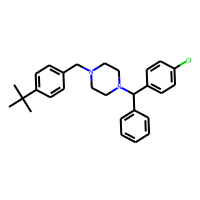
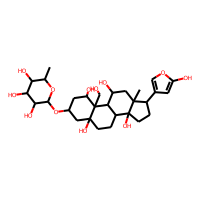
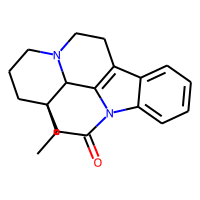
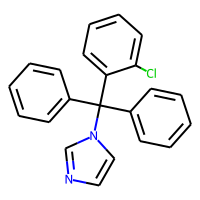
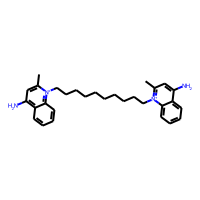

In [84]:
preprocessed_df_useful.loc[preprocessed_df_useful['PUBCHEM_ACTIVITY_OUTCOME']== 'Active', 'y_ture_lable'] = 1
preprocessed_df_useful.loc[preprocessed_df_useful['PUBCHEM_ACTIVITY_OUTCOME']== 'Inactive', 'y_ture_lable'] = 0
preprocessed_df_useful.head(5)

In [85]:
preprocessed_df_useful[desc_cols].describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.0,...,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000
mean,11.134862,-1.351147,11.134862,0.232986,0.554739,375.880708,351.863130,375.383726,138.016441,0.0,...,0.073983,0.091245,0.014797,0.007398,0.010275,0.021373,0.000411,0.022195,0.934649,0.031237
std,2.729259,1.712799,2.729259,0.497562,0.231671,117.092891,110.250199,117.006190,46.149532,0.0,...,0.303951,0.343970,0.120763,0.085712,0.100866,0.152943,0.020274,0.160695,3.022572,0.180945
min,2.203562,-9.769375,2.203562,0.000000,0.026680,250.190000,216.198000,247.852088,26.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.711079,-1.883522,10.711079,0.046222,0.370423,293.725000,274.175000,293.164046,108.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.997428,-0.823555,11.997428,0.117904,0.585861,344.313000,322.211000,343.962814,126.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.726099,-0.242563,12.726099,0.256531,0.754026,416.304000,390.337000,415.345030,154.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.767970,1.369141,15.767970,8.764932,0.944994,899.128000,848.654000,898.507857,358.000000,0.0,...,3.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,33.000000,2.000000


In [86]:
preprocessed_df_useful[desc_cols].dropna(inplace=True)
preprocessed_df_useful[desc_cols].isnull().values.any()

<ipython-input-86-43cd96147512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_df_useful[desc_cols].dropna(inplace=True)


False

In [87]:
preprocessed_df_useful.reset_index(inplace=True)

In [88]:
#Morgan2 FP
def get_morgan2(mol):
    return list(AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048))

In [89]:
preprocessed_df_useful['fp'] = preprocessed_df_useful.Molecule.apply(get_morgan2) #doesn't work if save the fp in one column

In [90]:
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]
preprocessed_df_useful[morgan2_cols] = preprocessed_df_useful.fp.to_list()

In [91]:
#shuffel the data when train and test split
from sklearn.model_selection import train_test_split
subset1, subset2 = train_test_split(preprocessed_df_useful, test_size= 0.2, random_state=42)
print(len(subset1), len(subset2))

1946 487


In [92]:
subset1["y_ture_lable"].value_counts(), subset2["y_ture_lable"].value_counts()

(0.0    1779
 1.0     167
 Name: y_ture_lable, dtype: int64,
 0.0    449
 1.0     38
 Name: y_ture_lable, dtype: int64)

In [93]:
subset1.to_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/pubchem/pubchem_trainset_featurized.csv', index=False)
subset2.to_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/pubchem/pubchem_testset_featurized.csv', index=False)

In [94]:
subset1_withoutfeatures = subset1[["preprocessedSmiles", "PUBCHEM_SID", "y_ture_lable"]]
subset2_withoutfeatures = subset2[["preprocessedSmiles", "PUBCHEM_SID", "y_ture_lable"]]
subset1_withoutfeatures.to_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/pubchem/pubchem_trainset.csv', index=False)
subset2_withoutfeatures.to_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/pubchem/pubchem_testset.csv', index=False)